# Particle Tracking in Malta's Territorial Waters

This Jupyter notebook contains the steps for simulating the movement of particles in the waters around Malta using ocean current data. The objective is to track particles over time to understand the potential path of any floating objects.

In [31]:
# Importing necessary libraries
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, StatusCode
from parcels import Variable, ParcelsRandom
import numpy as np
from datetime import timedelta, datetime
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

## Data Loading

The ocean current data is loaded from a NetCDF file, which includes information on the velocity of water in both the U (eastward) and V (northward) directions. The `FieldSet` object from Parcels is used to hold this data.


In [32]:
data_path = 'med-cmcc-cur-rean-h_1694161199370.nc'
# Check if the file exists
if not os.path.exists(data_path):
    print(f"The file {data_path} does not exist.")
else:
    print(f"The file {data_path} exists.")


# Define the fieldset from the NetCDF file
filenames = {
    'U': data_path,
    'V': data_path
}
variables = {
    'U': 'uo',
    'V': 'vo'
}
dimensions = {
    'lat': 'lat',
    'lon': 'lon',
    'time': 'time'
}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

The file med-cmcc-cur-rean-h_1694161199370.nc exists.


## Simulation Setup

We set up the simulation with 100 particles, randomly distributed within a defined region around the Maltese Islands. The particles will be simulated on the surface, with a temporal resolution of one hour.


In [33]:
# Simulation parameters
num_particles = 100  # Number of particles
release_zone = ((13.916667, 35.604168), (14.791667, 36.3125))  # Coordinates of the release zone (SW and NE corners)
start_time = fieldset.U.grid.time[0]  # This should be the time you want your particles to start at

# Generate random starting positions for the particles within the release zone
np.random.seed(0)  # For reproducibility
release_lons = np.random.uniform(release_zone[0][0], release_zone[1][0], num_particles)
release_lats = np.random.uniform(release_zone[0][1], release_zone[1][1], num_particles)

# Create a ParticleSet with particles at the release points and a specified start time
pset = ParticleSet(
    fieldset=fieldset,
    pclass=JITParticle,
    lon=release_lons,
    lat=release_lats,
    time=start_time 
)

## Handling Out-of-Bounds Particles

To ensure the simulation runs smoothly, particles that move outside the boundaries are deleted. This is achieved using a recovery kernel.


## Running the Simulation

The simulation is executed over 10 days with a temporal resolution of one hour. The particles are advected using the fourth-order Runge-Kutta method, and their positions are recorded hourly.


In [34]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

# Combine the AdvectionRK4 kernel with the DeleteParticle kernel
# The recovery dictionary is passed when creating the custom kernel
custom_kernel = pset.Kernel(AdvectionRK4) + pset.Kernel(DeleteParticle)
recovery = {'ErrorOutOfBounds': DeleteParticle}

output_file_name = 'particle_trajectory.zarr'
output_file = pset.ParticleFile(name=output_file_name, outputdt=timedelta(hours=1))

# Ensure particles have been added to the ParticleSet
if len(pset) == 0:
    raise ValueError("ParticleSet is empty. Ensure particles are correctly initialized before executing.")

# Check if all particles have valid time and time_nextloop data
for p in pset:
    if np.isnan(p.time) or np.isnan(p.time_nextloop):
        raise ValueError(f"Particle {p.id} times are not correctly initialized.")

# Now execute the particle set with the combined kernel
try:
    pset.execute(
        custom_kernel,
        runtime=timedelta(days=10),
        dt=timedelta(minutes=60),
        output_file=output_file
    )
except Exception as e:
    print(f"An error occurred during execution: {e}")

INFO: Output files are stored in particle_trajectory.zarr.
  0%|          | 0/864000.0 [00:00<?, ?it/s]WARNING: ParticleSet is empty on writing as array at time 0
  0%|          | 3600.0/864000.0 [00:00<00:33, 25811.32it/s]WARNING: ParticleSet is empty on writing as array at time 3600
  2%|▏         | 14400.0/864000.0 [00:00<00:14, 60127.02it/s]WARNING: ParticleSet is empty on writing as array at time 14400
  3%|▎         | 25200.0/864000.0 [00:00<00:10, 78166.03it/s]WARNING: ParticleSet is empty on writing as array at time 25200
  4%|▍         | 36000.0/864000.0 [00:00<00:09, 82828.55it/s]WARNING: ParticleSet is empty on writing as array at time 36000
  5%|▌         | 46800.0/864000.0 [00:00<00:09, 89545.63it/s]WARNING: ParticleSet is empty on writing as array at time 46800
  7%|▋         | 57600.0/864000.0 [00:00<00:09, 81405.60it/s]WARNING: ParticleSet is empty on writing as array at time 57600
  8%|▊         | 68400.0/864000.0 [00:00<00:10, 77535.58it/s]WARNING: ParticleSet is empt

## Visualization

The particle trajectories are visualized on a map with the coastlines of the Maltese Islands for context. This gives an intuitive representation of where the particles travel over the simulation period.


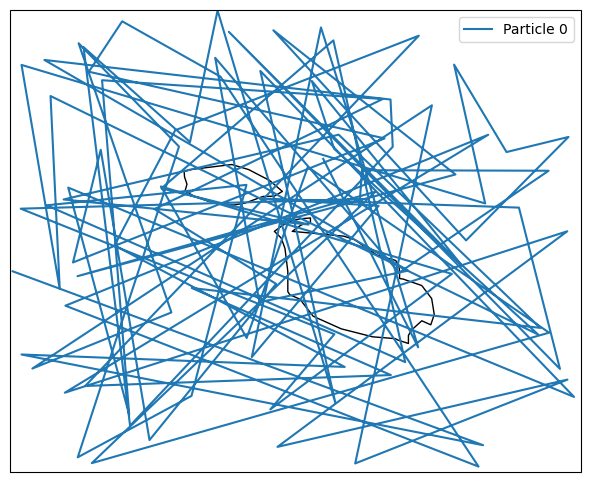

In [36]:
# Load the trajectory data from the output file
ds = xr.open_zarr(output_file_name)

# Create a simple plot of particle trajectories
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([release_zone[0][0], release_zone[1][0], release_zone[0][1], release_zone[1][1]], crs=ccrs.PlateCarree())

# Add coastlines for context
ax.coastlines(resolution='10m')

# Plot the particle trajectories
num_available_particles = ds.lon.shape[1]  # Assuming the particle index is the second dimension
for i in range(num_available_particles):
    plt.plot(ds.lon[:, i], ds.lat[:, i], transform=ccrs.Geodetic(), label=f'Particle {i}')

plt.legend()
plt.show()

## Saving the Output

The final visualization is saved as a PNG file, which can be used for further analysis or presentation purposes.


In [ ]:
# Save the figure
fig_path = '/mnt/data/particle_trajectories.png'
plt.savefig(fig_path)

## Download the Figure

Use the link below to download the visualization of the particle trajectories.


In [ ]:
# Generate a download link for the output figure
#fig_link = f'/mnt/data/particle_trajectories.png'
#print(f"Download the figure at: {fig_link}")